In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
%matplotlib inline
#%pylab inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import athena4_read as ath

# 1. construct the current data
## 1.1 load 3d data

In [2]:
t,x,y,z,data=ath.vtk('Unstra.0080.vtk')
bx = data['cell_centered_B'][...,0]
by = data['cell_centered_B'][...,1]
bz = data['cell_centered_B'][...,2]

time =  2481.862
face_dimensions =  [65, 257, 257]
-5.000000e-01 -2.000000e+00 -2.000000e+00
box_origin =  [-0.5, -2.0, -2.0]
1.562500e-02 1.562500e-02 1.562500e-02
grid_spacing =  [0.015625, 0.015625, 0.015625]
cell_dimensions =  [256 256  64]  num_cells =  4194304
SCALARS
start loading scalars !! 
loading array_name =  density
is,ie =  297 16777513
data[density].shape=  (256, 256, 64)
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  momentum
VECTORS
VECTORS
start loading vectors !! 
loading array_name =  cell_centered_B


## 1.2 construct $\mathbf{j} = \nabla \times \mathbf{B}$ 
* use cell-centered B with second order accurate central differences gradient to calculate the current density; so the derived j is also on cell center. 

In [3]:
def curl(vx,vy,vz):
  [dzvx,dyvx,dxvx] = np.gradient(vx)
  [dzvy,dyvy,dxvy] = np.gradient(vy)
  [dzvz,dyvz,dxvz] = np.gradient(vz)
  cx = dyvz-dzvy
  cy = dzvx-dxvz
  cz = dxvy-dyvx
  return cx,cy,cz

dx = dy = dz = x[1]-x[0]
jx,jy,jz = curl(bx,by,bz)/dx
j2 = jx**2+jy**2+jz**2

In [7]:
bx.shape

(256, 256, 64)

### see if the calculated current make sense by plotting $B_y$ and $j_x$, as $j_x = -\partial_z B_y + ...$, and $j^2$

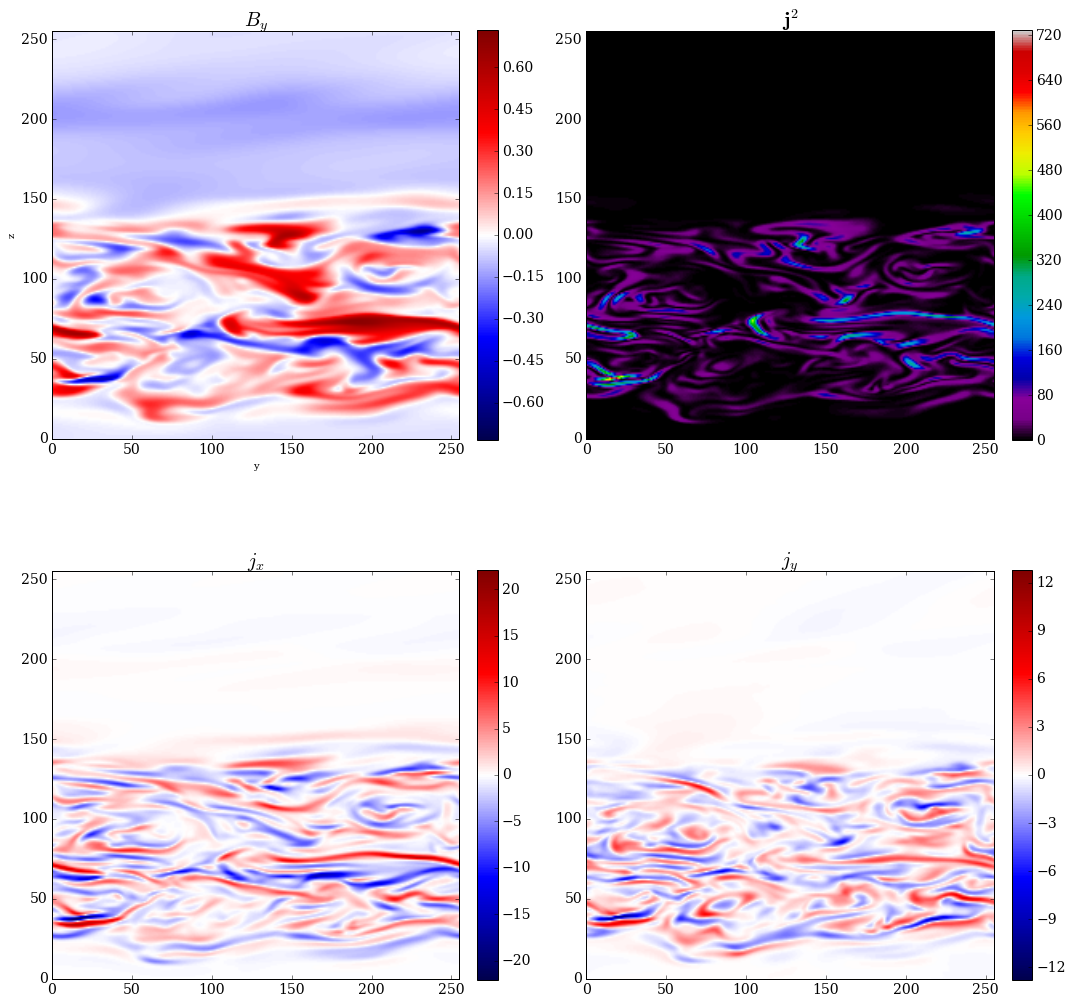

In [6]:
nframe = 2
nplot  = 2
cnt = 1
matplotlib.rcParams['figure.figsize'] = (15, 15.0*nframe/nplot)
fraction=0.046;pad=0.04

xslice = 0
ymin = 50; ymax=150 #255
zmin = 50;  zmax=150 #255

ymin=0; zmin=0
ymax=255; zmax=255

vmax = np.max([np.min(by)**2,np.max(by)**2])
vmax = vmax**0.5
vmin = -vmax
plt.subplot(nframe,nplot,cnt)
plt.imshow(by[:,:,xslice],origin='lower',vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(fraction=fraction,pad=pad)
plt.xlim(ymin,ymax)
plt.ylim(zmin,zmax)
plt.xlabel('y')
plt.ylabel('z')
plt.title(r'$B_y$',size=20)

cnt+=1
vmax = np.max(j2)
plt.subplot(nframe,nplot,cnt)
plt.imshow(j2[:,:,xslice],origin='lower',vmin=0,vmax=vmax,cmap='spectral')
plt.colorbar(fraction=fraction,pad=pad)
plt.xlim(ymin,ymax)
plt.ylim(zmin,zmax)
plt.title(r'$\mathbf{j}^2$',size=20)

cnt+=1
vmax = np.max([np.min(jx)**2,np.max(jx)**2])
vmax = vmax**0.5
vmin = -vmax
plt.subplot(nframe,nplot,cnt)
plt.imshow(jx[:,:,xslice],origin='lower',vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(fraction=fraction,pad=pad)
plt.xlim(ymin,ymax)
plt.ylim(zmin,zmax)
plt.title(r'$j_x$',size=20)

cnt+=1
vmax = np.max([np.min(jy)**2,np.max(jy)**2])
vmax = vmax**0.5
vmin = -vmax
plt.subplot(nframe,nplot,cnt)
plt.imshow(jy[:,:,xslice],origin='lower',vmin=vmin,vmax=vmax,cmap='seismic')
plt.colorbar(fraction=fraction,pad=pad)
plt.xlim(ymin,ymax)
plt.ylim(zmin,zmax)
plt.title(r'$j_y$',size=20)



plt.tight_layout()

# the strongest j2 index (for comparison with the 3d struture show below)
#a = j2[:,:,xslice]
#print a.index(max(a))

# 2. search for the current sheet based on $j^2$

## 2.1. find the threshold $j^2$ above which we define current sheet

In [6]:
# estimate the j_threshold => 25% of the total dissipation having j>j_threshold;
j2min=np.min(j2)
j2max=np.max(j2)
diss = np.sum(j2)*0.25
print np.sum(j2)
for jth in np.arange(1,int(j2max)+1,0.1):
    if (np.sum(j2[j2>float(jth)]))< diss:
      print jth
      break
        
print 'find threshold current sheet magnitude'
print 'jth = ',jth,' for 25% of total(j^2) above this value'
print 'total diss = ',np.sum(j2),'25% close to ', np.sum(j2[j2>jth])

    

49356290.5363
118.1
find threshold current sheet magnitude
jth =  118.1  for 25% of total(j^2) above this value
total diss =  49356290.5363 25% close to  12326053.6431


## 2.2. extract locations of individual current sheets with feature finding algorithm
* based on connected-component labeling algorithm
* assuming 4-connectivity

In [7]:
import numpy as np
import scipy.ndimage.measurements as measurements
import scipy.ndimage.morphology as morphology
from discrete_cmap import discrete_cmap
#import discrete_cmap


jth = 118.1 # threshold for j^2
s=morphology.generate_binary_structure(3,1) # 1: 6-pts connection ; 2: 34(?)-pts connection
data = np.copy(j2)
data[data < jth] = 0.
labeled_array, num_features = measurements.label(data, structure=s)

print num_features

831


## 2.3. construct, sort (volume based) and store current sheet list as list of dictionary

In [8]:
print 'there are ', num_features, ' current sheets in total'

# construct current sheet list based on the label_array
jlist = []
for i in range(1,num_features+1):
  jsheet = {}
  for loc in (np.argwhere(labeled_array == i)):
    jsheet[(loc[0],loc[1],loc[2])] = j2[loc[0],loc[1],loc[2]]
  if jsheet: 
    jlist.append(jsheet)

# sort the list based on length
jlist_sorted = sorted(jlist,key= lambda sheet: -len(sheet))

print 'first top 5 largest sheets: ',[len(jlist_sorted[i]) for i in range(0,5)]

# store dict list with pickle
import cPickle as pickle
pickle.dump(jlist_sorted, open( "jlist.p", "wb" ),2)

there are  831  current sheets in total
first top 5 largest sheets:  [7355, 4885, 4683, 3162, 2453]


## 2.4 restore pickled data

In [3]:
import cPickle as pickle
jlist_sorted = pickle.load( open( "jlist.p", "rb" ) )
print len(jlist_sorted[2])

4683


# 3. visualize 
## 3.1. the top 6 sheets (interactive scattering plots)
* **<font color='orange'>some sheets go across the shearing boundaries.</font>**

<IPython.core.display.Javascript object>


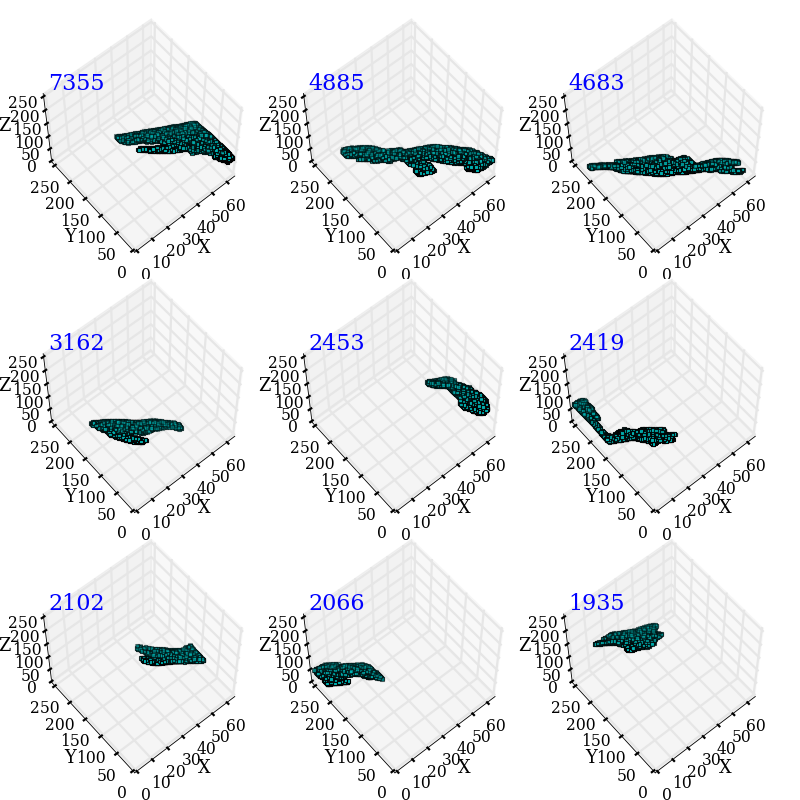

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook
#show the first six sheets largest in size
nframe = 3
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (10, 10.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04

gs = gridspec.GridSpec(3, 3)
for i in range(0,9):
  locs = np.array(jlist_sorted[i].keys())
  nlocs = len(locs[:,0])
  ax = fig.add_subplot(gs[i], projection='3d')
  ax.scatter(locs[:,2], locs[:,1], locs[:,0],marker='s',c='c',s=10)
  #ax.plot_wireframe(locs[:,2],locs[:,1],locs[:,0],rstride=20,
  #                     cstride=20,
  #                     color='DarkSlateBlue',
  #                     linewidth=1,
  #                     antialiased=True)
  ax.set_xlim3d(0, 64)
  ax.set_ylim3d(0, 255)
  ax.set_zlim3d(0, 255)

  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.text(0, 250, 280, str(nlocs), zdir=None,color='b',size=20)
  ax.view_init(elev=60, azim=230)

plt.tight_layout()


## 3.2. reverse search: given (x,y,z) find jsheet {} (if the grid point is in the sheet) to visualize 

In [6]:
#from mpl_toolkits.axes_grid1 import make_axes_locatable

# can we search for the current given a point on the grid? 
(s,t,v) = (59, 124, 21)  #jlist[2] # jlist[5] <--(80,100,16) # a given point
#print jlist_sorted[2].keys()

for i in range(0,len(jlist_sorted)):
  if (s,t,v) in jlist_sorted[i]:
    print 'find grid point (',s,',',t,',',v,') at jlist_sorted[',i,'].'
    jsheet = jlist_sorted[i]
    break
    
print len(jsheet.values())

find grid point ( 59 , 124 , 21 ) at jlist_sorted[ 2 ].
4683


## 3.3. visualize a single sheet with details
* take the third largest sheet for example

(4683, 3)
531.892798871 118.123545842


<IPython.core.display.Javascript object>


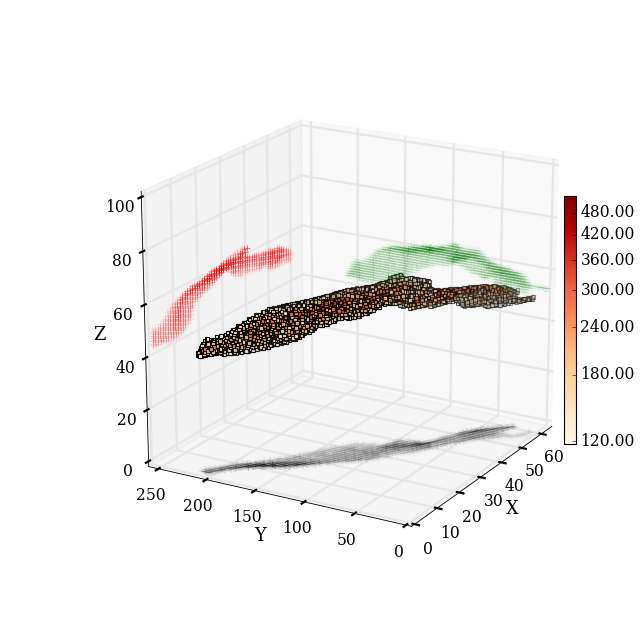

In [21]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook

# prepare grid points with sheet found above
locs = np.array(jsheet.keys())  
print locs.shape
cs = (np.array(jsheet.values()))
print max(cs),min(cs)

#
# create a mappable colormap based on the value of j^2 in log scale
#
#cNorm = matplotlib.colors.Normalize(vmin=np.min(cs), vmax=np.max(cs))
cNorm = matplotlib.colors.LogNorm(vmin=np.min(cs), vmax=np.max(cs))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('OrRd'))
#print scalarMap.to_rgba(cs)

# create the scatter plot
matplotlib.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure()
fraction=0.025;pad=-0.1
ax = fig.gca(projection='3d')
#ax = Axes3D(fig)
ax.scatter(locs[:,2], locs[:,1], locs[:,0],marker='s',s=10,c=scalarMap.to_rgba(cs))
scalarMap.set_array(cs)
# fiddling with the color-bar
cb=fig.colorbar(scalarMap,fraction=fraction,pad=pad,orientation='vertical',format='%.2f')
tick_locator = matplotlib.ticker.MaxNLocator(nbins=8)
cb.locator = tick_locator
cb.update_ticks()

# add 2d projections
ax.plot(locs[:,2], locs[:,0], 'r+', zdir='y', zs=256, alpha=0.05)
ax.plot(locs[:,1], locs[:,0], 'g+', zdir='x', zs=64, alpha=0.05)
ax.plot(locs[:,2], locs[:,1], 'k+', zdir='z', zs=0., alpha=0.05)

ax.set_xlim3d(0, 64)
ax.set_ylim3d(0, 255)
ax.set_zlim3d(0, 100) #255)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=210) 

## 3.4. number count of current sheet list

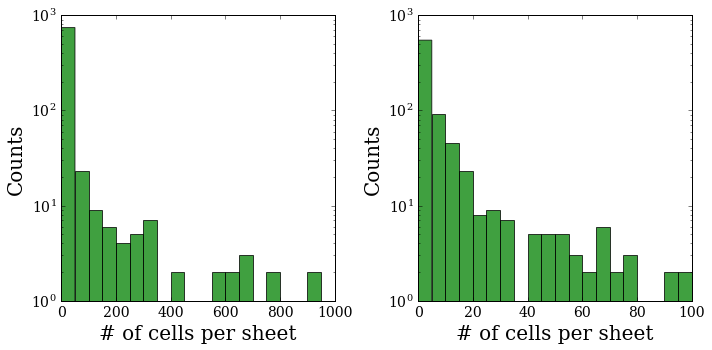

In [37]:
%matplotlib inline
import matplotlib.gridspec as gridspec

cell_per_sheet = []
for jsheet in jlist_sorted: 
  ncells = len(jsheet.values()) 
  cell_per_sheet.append(ncells)
#print cell_per_sheet

cell_small = [i for i in cell_per_sheet if i <=100]
#print cell_small



# show histogram of the projected distance for each cells in each principle component direction
nframe = 1
nplot  = 2
matplotlib.rcParams['figure.figsize'] = (10, 10.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04


gs = gridspec.GridSpec(1, 2)
for i in range(2):
  fig.add_subplot(gs[i])
  if (i == 0):
    n, bins, patches = plt.hist(cell_per_sheet, 20, normed=False,range=[0,1000], facecolor='green', alpha=0.75)
  if (i == 1):
    n1, bins1, patches1 = plt.hist(cell_small, 20, normed=False, range=[0,100],facecolor='green', alpha=0.75)
  plt.xlabel('# of cells per sheet',size=20)
  #plt.locator_params(axis='x',nbins=10)
  plt.ylabel('Counts',size=20)
  plt.gca().set_yscale("log")

#plt.text (80,450,size_label,rotation=90,size=13)
plt.tight_layout()

In [24]:
## test Pickle an interactive plot. 
## still image could be stored, but the interactive data was lost.
#pickle.dump(fig, file('single_current_sheet_3d.pickle', 'wb'))
#fig = pickle.load(file('single_current_sheet_3d.pickle'))
#plt.show()

# 4. Analysis of current sheets

## 4.1.  dimensions of jsheet ($\lambda,\xi,l$)  (PCA modelling)
### 4.1.1 first compute the component vectors (first 3)

In [13]:
from sklearn.decomposition import PCA
# prepare grid points with sheet found above
locs = np.array(jsheet.keys()) 

pca = PCA(n_components=3)
pca.fit(locs)
#PCA(copy=True, n_components=3, whiten=False)
print(pca.components_) 
print locs.shape

[[ 0.03739264 -0.95756698  0.28577487]
 [ 0.98947519 -0.00452506 -0.14463184]
 [ 0.13978782  0.28817531  0.94731956]]
(4683, 3)


* lets construct lines to represent the 3 orthogonal vectors that can be plotted on the scattered sheet plot.

In [14]:
stride = np.arange(300).reshape(1,300)
v1 = pca.components_[0].reshape(3,1).dot(stride)
stride = np.arange(50).reshape(1,50)
v2 = pca.components_[1].reshape(3,1).dot(stride)
stride = np.arange(30).reshape(1,30)
v3 = pca.components_[2].reshape(3,1).dot(stride)
print sum(v3[:,:29]*v2[:,:29]) # check if they are orthogonal

[  0.00000000e+00  -2.77555756e-17  -1.11022302e-16  -2.22044605e-16
  -4.44089210e-16  -1.33226763e-15  -8.88178420e-16   8.88178420e-16
  -1.77635684e-15  -3.55271368e-15  -5.32907052e-15  -3.55271368e-15
  -3.55271368e-15  -3.55271368e-15   3.55271368e-15  -3.55271368e-15
  -7.10542736e-15   0.00000000e+00  -1.42108547e-14  -1.42108547e-14
  -2.13162821e-14  -1.42108547e-14  -1.42108547e-14  -2.84217094e-14
  -1.42108547e-14  -1.42108547e-14  -1.42108547e-14  -1.42108547e-14
   1.42108547e-14]


* then we could add the vectors to previous plot to shown the geometry of the sheet.

531.892798871 118.123545842


<IPython.core.display.Javascript object>


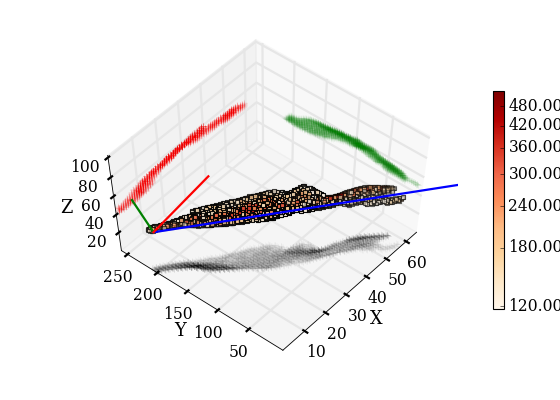

In [15]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook

# prepare grid points with sheet found above
locs = np.array(jsheet.keys())    
cs = (np.array(jsheet.values()))
print max(cs),min(cs)

#
# create a mappable colormap based on the value of j^2 in log scale
#
#cNorm = matplotlib.colors.Normalize(vmin=np.min(cs), vmax=np.max(cs))
cNorm = matplotlib.colors.LogNorm(vmin=np.min(cs), vmax=np.max(cs))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('OrRd'))
#print scalarMap.to_rgba(cs)

# create the scatter plot
matplotlib.rcParams['figure.figsize'] = (7, 5)
fig = plt.figure()
fraction=0.025;pad=0.08
ax = fig.gca(projection='3d')
#ax = Axes3D(fig)
ax.scatter(locs[:,2], locs[:,1], locs[:,0],marker='s',s=10,c=scalarMap.to_rgba(cs))
scalarMap.set_array(cs)
# fiddling with the color-bar
cb=fig.colorbar(scalarMap,fraction=fraction,pad=pad,orientation='vertical',format='%.2f')
tick_locator = matplotlib.ticker.MaxNLocator(nbins=8)
cb.locator = tick_locator
cb.update_ticks()

# add 2d projections
ax.plot(locs[:,2], locs[:,0], 'r+', zdir='y', zs=256., alpha=0.05)
ax.plot(locs[:,1], locs[:,0], 'g+', zdir='x', zs=64., alpha=0.05)
ax.plot(locs[:,2], locs[:,1], 'k+', zdir='z', zs=0., alpha=0.05)

# add principle component vectors
xshift=0;yshift=200;zshift=45
ax.plot(v1[2,:]+xshift,v1[1,:]+yshift,zs=v1[0,:]+zshift)
ax.plot(v2[2,:]+xshift,v2[1,:]+yshift,zs=v2[0,:]+zshift)
ax.plot(v3[2,:]+xshift,v3[1,:]+yshift,zs=v3[0,:]+zshift)

ax.set_xlim3d(1, 64)
ax.set_ylim3d(1, 255)
ax.set_zlim3d(1, 100) #255)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=58, azim=220)

### 4.1.2. Now with pca.components $\mathbf I_i$, calculate the geometrical size ($\lambda,\xi,l$)
* define the projected distance of a grid point $\mathbf{x_j}$ onto $\mathbf{I_i}$ as $d_{ij} = \mathbf{x_j}\cdot \mathbf{I_i}\, /\, ||\mathbf{I_i}||$
* define the length $\lambda$, width $\xi$, height $l$ as the difference between the largest and the smallest $d_{ij}$ for the 1st, 2nd and 3rd components 

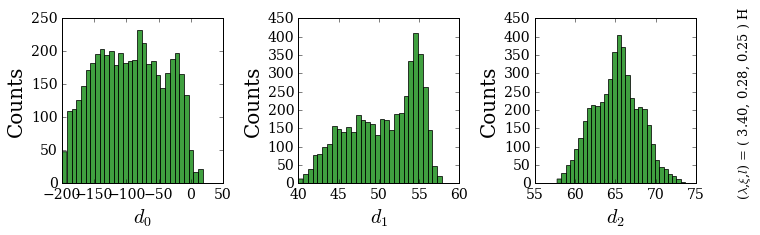

In [17]:
%matplotlib inline
# calc x\cdot I_1
#print len(locs[:,0])
iz = locs[:,0]; iy = locs[:,1]; ix = locs[:,2]
i1 = pca.components_[0]; i2= pca.components_[1]; i3 = pca.components_[2]
d1 = np.array([locs[i,:].dot(i1) for i in range(0,len(locs[:,0]))])
d2 = np.array([locs[i,:].dot(i2) for i in range(0,len(locs[:,0]))])
d3 = np.array([locs[i,:].dot(i3) for i in range(0,len(locs[:,0]))])

# dimensions of the sheet
L1 = max(d1)-min(d1)
L2 = max(d2)-min(d2)
L3 = max(d3)-min(d3)
dx = x[1]-x[0]
size_label = '({},{},{}) = ({:5.2f},{:5.2f},{:5.2f} ){}'.format(r'$\lambda$',r'$\xi$',r'$l$',L1*dx,L2*dx,L3*dx,' H')

# show histogram of the projected distance for each cells in each principle component direction
nframe = 1
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (10, 10.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04

gs = gridspec.GridSpec(1, 3)
for i in range(3):
  if (i==0):
    distance = d1
  if (i==1):
    distance = d2
  if (i==2):
    distance = d3
  fig.add_subplot(gs[i])
  n, bins, patches = plt.hist(distance, 30, normed=False, facecolor='green', alpha=0.75)
  plt.xlabel(r'$d_{}$'.format(str(i)),size=20)
  plt.locator_params(axis='x',nbins=6)
  plt.ylabel('Counts',size=20)
  #plt.title('Histogram of '+r' $d_{}:$'.format(str(i)),size=16)

plt.text (80,450,size_label,rotation=90,size=13)
plt.tight_layout()



## 4.2. statistics of jlist (PDF, correlation etc.)
### 4.2.1  compute $\epsilon$, and $(\lambda,\xi,l)$ for all current sheets in jlist.

In [5]:
from sklearn.decomposition import PCA
# (1) load the jlist_sorted
##import cPickle as pickle
##jlist_sorted = pickle.load( open( "jlist.p", "rb" ) )
nlist = len(jlist_sorted)
pca = PCA(n_components=3)

# (2) for each jsheet in jlist_sorted:
jmax = []; diss = []; size = []; ncells = []
eta = 1.0; dx = x[1]-x[0]; dv= dx**3
for j in range(0,nlist):
  js = jlist_sorted[j]
# num of cells in given sheet
  ncells.append(len(js))
# find j_max
  maxj = np.max(np.array(js.values()))
  jmax.append(maxj)
# compute dissipation \epsilon
  eps  = np.sum(eta*np.array(js.values()))*dv
  diss.append(eps)
# compute (lambda,xi,l)
  locs = np.array(js.keys())  
  if (len(locs[:,0])>=9):
    pca.fit(locs) 
    i1 = pca.components_[0]; i2= pca.components_[1]; i3 = pca.components_[2]
    d1 = np.array([locs[i,:].dot(i1) for i in range(0,len(locs[:,0]))])
    d2 = np.array([locs[i,:].dot(i2) for i in range(0,len(locs[:,0]))])
    d3 = np.array([locs[i,:].dot(i3) for i in range(0,len(locs[:,0]))])
    # dimensions of the sheet
    L1 = np.max([dx*(max(d1)-min(d1)),dx])
    L2 = np.max([dx*(max(d2)-min(d2)),dx])
    L3 = np.max([dx*(max(d3)-min(d3)),dx])
    size.append((L1,L2,L3))
  # else:
  #  size.append((0,0,0))
print 'j_max[:5]         = ',jmax[0:5]
print 'max(j_max[:])     = ',np.max(jmax)
print
print 'Ohmic dissipation = ',diss[:5]
print 'geomtry size[:5]  = ',size[:5]
print
print 'number of sheets > 9cells = ', len(size)
print '# of cells[:5]    = ',ncells[:5]

j_max[:5]         =  [686.74155776460566, 618.13438426740265, 531.89279887080556, 499.64210840921578, 689.27151289399137]
max(j_max[:])     =  729.863448625

Ohmic dissipation =  [6.0857535272092349, 3.7519749139305905, 3.5000047734676931, 2.2028994678987646, 2.0317410320901761]
geomtry size[:5]  =  [(3.073606132801507, 0.52190953911324345, 0.34036640587605094), (3.3979163389647695, 0.36185335212487835, 0.23093395243843473), (3.4017932244901496, 0.27844109765188474, 0.24756636409376043), (1.9097950097782947, 0.42046817865074193, 0.17571186337521261), (1.9150985789889694, 0.2191441468123001, 0.19650677988184129)]

number of sheets > 9cells =  204
# of cells[:5]    =  [7355, 4885, 4683, 3162, 2453]


### 4.2.2 histogram of $j_{max}$, $\epsilon$, and size for all sheets

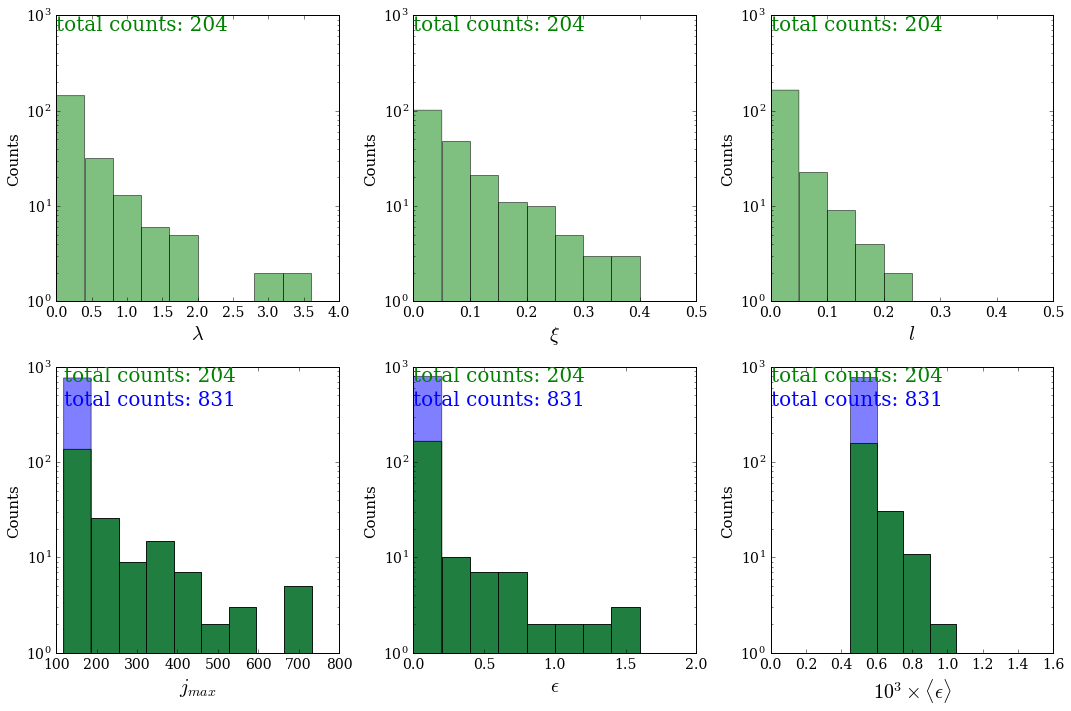

In [13]:
import matplotlib.gridspec as gridspec

jth=118.1
#print size
nframe = 2
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (15, 15.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04
gs = gridspec.GridSpec(2, 3)
for i in np.arange(6):
  if (i==3):
    hdata = jmax
    vrange = (jth,800)
    nbins=10
    xlab = r'$j_{max}$'
  if (i==4):
    hdata = diss
    vrange = (0,2)
    nbins = 10
    xlab = r'$\epsilon$'
  if (i==5):
    hdata = np.array(diss)/np.array(ncells)*1e3
    vrange = (0,1.5)
    nbins = 10
    xlab = r'$10^3\times\langle\epsilon\rangle$'
  if (i==0):
    hdata = np.array(size)[:,0]
    vrange = (0,4)
    nbins = 10
    xlab = r'$\lambda$'
  if (i==1):
    hdata = np.array(size)[:,1]
    vrange = (0,0.5)
    nbins = 10
    xlab = r'$\xi$'
  if (i==2):
    hdata = np.array(size)[:,2]
    vrange = (0,0.5)
    nbins = 10
    xlab = r'$l$'
  fig.add_subplot(gs[i])
  if (i< 3): 
    n, bins, patches = plt.hist(hdata, nbins, normed=False, facecolor='green', range=vrange, alpha=0.75)
    plt.text(vrange[0],700,'total counts: '+str(len(hdata)),size=20,color='g')
  else:
     n, bins, patches = plt.hist(hdata, nbins, normed=False, facecolor='blue', range=vrange, alpha=0.5)
     n1, bins1, patches1 = plt.hist(hdata[:len(np.array(size)[:,0])], 
                                    nbins, normed=False, facecolor='green', range=vrange, alpha=0.75)
     plt.text(vrange[0],700,'total counts: '+str(len(np.array(size)[:,0])),size=20,color='g')
     plt.text(vrange[0],400,'total counts: '+str(len(hdata)),size=20,color='b')   
  
  plt.xlabel(xlab,size=20)
  plt.ylabel('Counts',size=15)
  #plt.gca().set_xscale("log")
  plt.gca().set_yscale("log")
  #if (i< 3): 
  #  plt.text(vrange[0],700,'total counts: '+str(len(hdata)),size=20,color='g')
  #else:
  #  plt.text(vrange[0],700,'total counts: '+str(len(np.array(size)[:,0])),size=20,color='g')
  #  plt.text(vrange[0],400,'total counts: '+str(len(hdata)),size=20,color='b')    
  #plt.title(r'$\mathrm{Histogram\ of\ d_i:}$')
plt.tight_layout()

### 4.2.3 PDF of Ohmic dissipation ($\epsilon = \int\! dv \,\eta j^2$)
### 4.2.4 PDF of $j_{max} \in $ jsheet
### 4.2.5 PDF of ($\lambda,\xi,l$)
### 4.2.6 Cross-correlation:  $\epsilon \circ j_{max}$, $\lambda\circ\xi$, ..., $\epsilon \circ (\lambda,\xi,l)$, ...

i =  0  xmin/xmax =  0.0444459556751 3.74197254694
i =  0  ymin/ymax =  0.0140625 0.574100493025
i =  1  xmin/xmax =  0.0444459556751 3.74197254694
i =  1  ymin/ymax =  0.0140625 0.374403046464
i =  2  xmin/xmax =  0.0140625 0.574100493025
i =  2  ymin/ymax =  0.0140625 0.374403046464
i =  3  xmin/xmax =  100 1000
i =  3  ymin/ymax =  0.000405519111955 6.69432887993
i =  4  xmin/xmax =  100 1000
i =  4  ymin/ymax =  0.405519111955 1.04939512859
i =  5  xmin/xmax =  1.73782781275e-05 0.600596535421
i =  5  ymin/ymax =  0.413019980624 1.04939512859


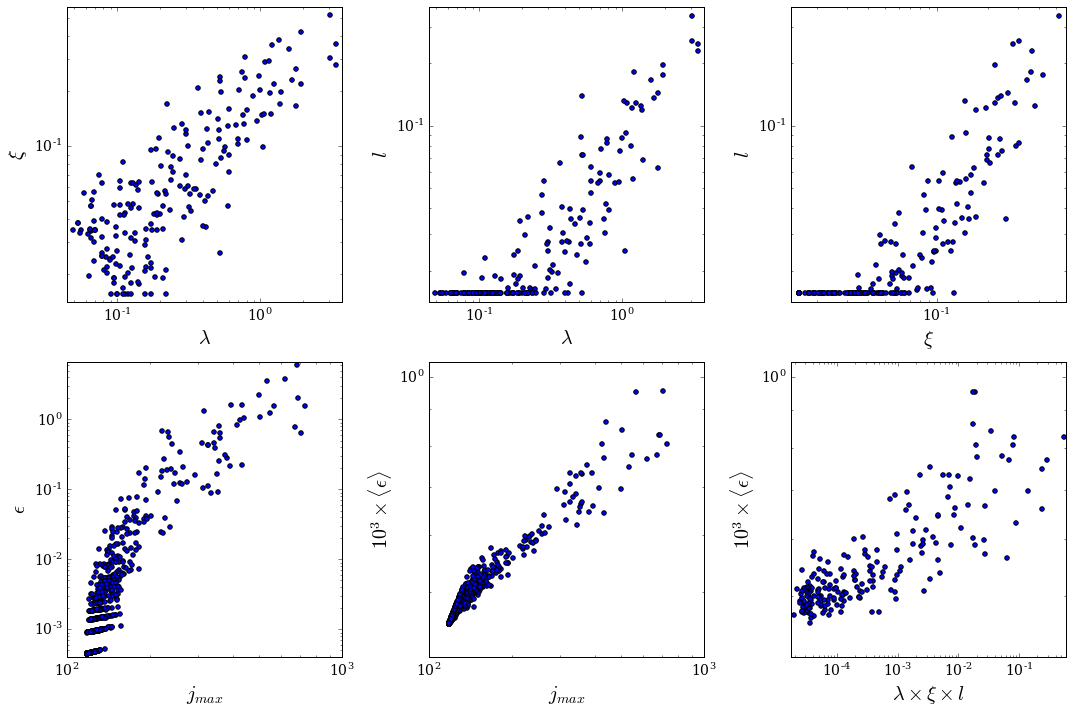

In [30]:
import matplotlib.gridspec as gridspec

nframe = 2
nplot  = 3
matplotlib.rcParams['figure.figsize'] = (15, 15.0*nframe/nplot)
fig = plt.figure()
fraction=0.046;pad=0.04
gs = gridspec.GridSpec(2, 3)
for i in np.arange(6):
  if (i==0):
    hdata_x = np.array(size)[:,0]
    hdata_y = np.array(size)[:,1]
    xlab = r'$\lambda$'
    ylab = r'$\xi$'
    xlim = (1e-3,5)
    ylim = (1e-2,1)
    
  if (i==1):
    hdata_x = np.array(size)[:,0]
    hdata_y = np.array(size)[:,2]
    xlab = r'$\lambda$'
    ylab = r'$l$'
    xlim = (1e-3,5)
    ylim = (1e-2,1)
  if (i==2):
    hdata_x = np.array(size)[:,1]
    hdata_y = np.array(size)[:,2]
    xlab = r'$\xi$'
    ylab = r'$l$'
    xlim = (1e-3,1)
  if (i==3):
    hdata_x = np.array(jmax)
    hdata_y = np.array(diss)
    xlab = r'$j_{max}$'
    ylab = r'$\epsilon$'
    xlim = (100,1000)
  if (i==4):
    hdata_x = np.array(jmax)
    hdata_y = np.array(diss)/np.array(ncells)*1e3
    xlab = r'$j_{max}$'
    ylab = r'$10^3\times\langle\epsilon\rangle$'
    xlim = (100,1000)
  if (i==5):
    hdata_x = np.array(size)[:,0]*np.array(size)[:,1]*np.array(size)[:,2]
    hdata_y = np.array(diss)/np.array(ncells)*1e3
    hdata_y = hdata_y[:len(hdata_x)]
    xlab = r'$\lambda\times\xi\times l$'
    ylab = r'$10^3\times\langle\epsilon\rangle$'
    xlim = (1e-4,1.0)
    
  fig.add_subplot(gs[i])
  ax = plt.gca()
  ax.scatter(hdata_x,hdata_y,s=20, marker = 'o' );

   # linear regression
  #n_abovezero = np.min([len(hdata_x[hdata_x > 0]),len(hdata_y[hdata_y > 0])])
  #clean_data = np.log10(np.array(zip(hdata_x[:n_abovezero],hdata_y[:n_abovezero])))
  #print clean_data
  #coeff = np.polyfit(clean_data[:,0], clean_data[:,1], 1)
  #print coeff
  #break
  #yfit = 10**(coeff[0]*clean_data[:,0]+coeff[1])
  #ax.plot(clean_data[:,0],yfit,'r-')

  ax.set_xlabel(xlab,size=20)
  ax.set_ylabel(ylab,size=20)
  vmin = np.min(hdata_x)*0.9; vmax = np.max(hdata_x)*1.1
  if (vmin <= 0):
    vmin =1e-2
    if (i==5):
      vmin =1e-5
  if (i==3 or i==4):
    vmin = 100
    vmax = 1000
  ax.set_xlim(vmin,vmax)
  print 'i = ',i,' xmin/xmax = ',vmin,vmax
  
  vmin = np.min(hdata_y)*0.9; vmax = np.max(hdata_y)*1.1
  if (vmin <= 0):
    vmin =1e-2
    if (i==5):
      vmin =1e-1
  
  ax.set_ylim(vmin,vmax)
  print 'i = ',i,' ymin/ymax = ',vmin,vmax
  ax.set_xscale("log")
  ax.set_yscale("log")
  ax.axhline(linewidth=8) 
  ax.axvline(linewidth=8) 

 

  #plt.title(r'$\mathrm{Histogram\ of\ d_i:}$')
plt.tight_layout()

729.863448625 122.224355599
186.75456416 10.0


<IPython.core.display.Javascript object>


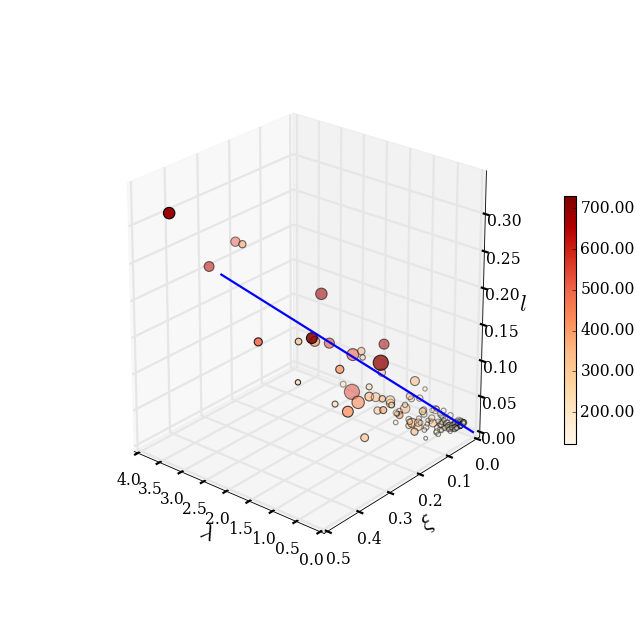

pca =  [-0.98855489 -0.12886525 -0.07844095]


In [28]:
lamb = np.array(size)[:,0]
xi   = np.array(size)[:,1]
ll   = np.array(size)[:,2]
nsheet = len(ll)

#
# try to visualize the 3d correlation
#
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
%matplotlib notebook

# prepare the color gradient which is used to present epsilon or jmax 
# and marker size for avg dissipation rate
cs = jmax[:nsheet]
print max(cs),min(cs)
ss = np.array(diss[:nsheet])/np.array(ncells[:nsheet])
ss = (ss/min(ss))**4*10
print max(ss),min(ss)
#nlev = 10.
#ss = min(ss)*10**(i*np.log10(max(ss)/min(ss))/nlev for i in range(10))


cNorm = matplotlib.colors.Normalize(vmin=np.min(cs), vmax=np.max(cs))
#cNorm = matplotlib.colors.LogNorm(vmin=np.min(cs), vmax=np.max(cs))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('OrRd'))
#print scalarMap.to_rgba(cs)

# create the scatter plot
matplotlib.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure()
fraction=0.025;pad=0.08
ax = fig.gca(projection='3d')


# add principle component vectors
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(np.array(size)) 
print 'pca = ',pca.components_[0]
stride = np.arange(300).reshape(1,300)
v1 = -pca.components_[0].reshape(3,1).dot(stride*0.01)
xshift=0;yshift=0;zshift=0
ax.plot(v1[0,:]+xshift,v1[1,:]+yshift,zs=v1[2,:]+zshift)

#ax = Axes3D(fig)
ax.scatter(lamb, xi, ll,marker='o',s=ss,c=scalarMap.to_rgba(cs))
scalarMap.set_array(cs)
# fiddling with the color-bar
cb=fig.colorbar(scalarMap,fraction=fraction,pad=pad,orientation='vertical',format='%.2f')
tick_locator = matplotlib.ticker.MaxNLocator(nbins=8)
cb.locator = tick_locator
cb.update_ticks()



ax.set_xlim3d(0, 4)
ax.set_ylim3d(0, 0.5)
ax.set_zlim3d(0, 0.35) #255)

ax.set_xlabel(r'$\lambda$',size=20)
ax.set_ylabel(r'$\xi$',size=20)
ax.set_zlabel(r'$l$',size=20)
ax.view_init(elev=22, azim=130)